In [ ]:
!pip install networkx
!pip install numpy
!pip install pandas
!pip install matplotlib.pyplot

In [ ]:
!pip uninstall torch torchvision torchtext torchdata torchaudio --yes
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0

In [ ]:
import networkx as nx
import os
import torch
import pandas
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=f4ad0b1e829687932dd4d7c2f48b95e5bc91d9d30393c57a380520b70b87d986
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
from torch_geometric.data import Data
from torch_geometric.datasets import EmailEUCore
from torch_geometric import nn
import torch_geometric.transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def two_subgraphs_weak_ties2(graph, nodes1, nodes2, labels):

    list_nodes = list(nodes1) + list(nodes2)
    subgraph_1_2=graph.subgraph(list_nodes)

    bc_dep1_dep2=nx.edge_betweenness_centrality(subgraph_1_2)

    sorted_bc_dep1_dep2 = sorted(bc_dep1_dep2.items(), key=lambda item: item[1], reverse=True) # list of tuples [(edges:tuple, value),(edges:tuple, value)]
    # print(sorted_bc_dep1_dep2)

    top_edges=[]

    for edge_tuple, value in sorted_bc_dep1_dep2:
      if len(top_edges) < 5:
          if (value != 0.0) and (labels[int(edge_tuple[0])][1] != labels[int(edge_tuple[1])][1]):
            top_edges.append(edge_tuple)

    if len(top_edges) == 0:
        return -1

    return top_edges

In [ ]:
##creating edges regardless of departments

def create_email_data():

  with open('Data/email-Eu-core.txt', 'rb') as f:
    graph = nx.read_edgelist(f)

  label_all = np.loadtxt('Data/email_labels.txt')

  n = graph.number_of_nodes()
  edge_labels_most_weakties = np.zeros((n, n),dtype=int)

  graph2  = graph.copy()
  graph_label_all2 = label_all.copy()
  graph_label_all2[:,1] = graph_label_all2[:,1]//6

  graph_weak_tie_node = label_all.copy()
  graph_weak_tie_node[:,1] = 0

  count = 0
  for edge in list(graph2.edges()):
    if graph_label_all2[int(edge[0])][1] != graph_label_all2[int(edge[1])][1]:
      graph2.remove_edge(edge[0], edge[1])
      count+=1

  for edge in list(graph2.edges()):
    edge_labels_most_weakties[int(edge[0]), int(edge[1])] = 1


  comps = [comp for comp in nx.connected_components(graph2) if len(comp)>10]
  graphs = [graph2.subgraph(comp) for comp in comps]

  new_community_labels = label_all.copy()
  new_community_labels[:,1] = 0

  for index, g in enumerate(graphs):
    print(g.number_of_nodes())
    for node in g.nodes():
      new_community_labels[int(node)][1] = index+1


  community_weak_ties_set = []

  for g in graphs:
    for h in graphs:
      list_graph_weak_ties = two_subgraphs_weak_ties2(graph, g.nodes(), h.nodes(), new_community_labels)
      if list_graph_weak_ties != -1:
        for weak_ties in list_graph_weak_ties:
          graph2.add_edge(weak_ties[0], weak_ties[1])
          community_weak_ties_set.append(weak_ties)
          edge_labels_most_weakties[int(weak_ties[0]), int(weak_ties[1])] = 2
          graph_weak_tie_node[int(weak_ties[0])][1] = 1
          graph_weak_tie_node[int(weak_ties[1])][1] = 1


  n = graph2.number_of_nodes()
  node_features = np.ones((n, 1))


  return graph2, node_features, graph_label_all2, new_community_labels, graph_weak_tie_node, edge_labels_most_weakties,


In [ ]:
def nx_to_tg_data(graph, feature, node_labels = None, edge_labels=None):
  data_list = []
  graph = graph.copy()
  # graph.remove_edges_from(graph.selfloop_edges())

  # relabel graphs
  keys = list(graph.nodes)
  vals = range(graph.number_of_nodes())
  mapping = dict(zip(keys, vals))
  nx.relabel_nodes(graph, mapping, copy=False)

  x = np.zeros(feature.shape)

  graph_nodes = list(graph.nodes)
  for m in range(feature.shape[0]):
      x[graph_nodes[m]] = feature[m]
  x = torch.from_numpy(x).float()

  if node_labels is not None:
    y = np.zeros(graph.number_of_nodes())
    for m in range(graph.number_of_nodes()):
      y[graph_nodes[m]] = node_labels[:,1][m]
    y = torch.from_numpy(y).float()

  # get edges
  edge_index = np.array(list(graph.edges))
  edge_index = np.concatenate((edge_index, edge_index[:,::-1]), axis=0)
  edge_index = torch.from_numpy(edge_index).long().permute(1,0)


  data = Data(x=x, y=y, edge_index=edge_index)

  for i, variable in enumerate([x, y, edge_index]):
    with open(file_paths[i], 'w') as file:
        file.write(str(variable))


  return data

In [ ]:
email_graph,email_node_features , email_graph_label, email_new_community_labels, weak_tie_node_label, edge_labels_most_weakties =create_email_data()

245
139
32
223
186
37
58


[[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 2.000e+00]
 ...
 [1.002e+03 0.000e+00]
 [1.003e+03 5.000e+00]
 [1.004e+03 2.000e+00]]


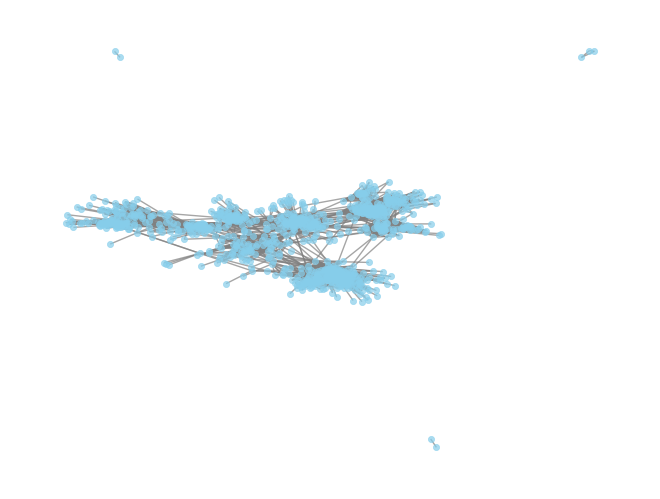

In [ ]:

print(email_new_community_labels)
email_graph.remove_edges_from(nx.selfloop_edges(email_graph))
email_graph.remove_nodes_from(list(nx.isolates(email_graph)))

# Draw the graph
pos = nx.spring_layout(email_graph)  # You can choose a different layout if needed
nx.draw(email_graph, pos, with_labels=False, node_size=20, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5, alpha=0.7)

# Show the plot
plt.show()

In [ ]:
#covert graph to data object of pytorch.
email_data = nx_to_tg_data(email_graph, email_node_features, weak_tie_node_label)

In [ ]:
edge_attr_dim = 1
edge_attr = torch.ones((email_data.edge_index.size(1), edge_attr_dim))

edge_labels = torch.zeros(len(email_data.edge_index[0]))


edge_list = [(src.item(), target.item()) for src, target in email_data.edge_index.t()]

for i, (src, target) in enumerate(edge_list):
    if email_data.y[src] == 1 and email_data.y[target] == 1:
      edge_labels[i] = 2
    elif email_data.y[src] == 1 and email_data.y[target] == 0:
        edge_labels[i] = 1


In [ ]:
email_data.edge_labels=edge_labels
email_data.edge_attr=edge_attr

In [ ]:
#safe email data object
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

In [ ]:
save_data(email_data, 'email_data.pkl')

In [ ]:
#split datases:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.15, num_test=0.15)
email_data2= split(email_data)
save_data(email_data, 'email_data2.pkl')